<a href="https://colab.research.google.com/github/viki6666/Pytorch_learn/blob/master/Optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11


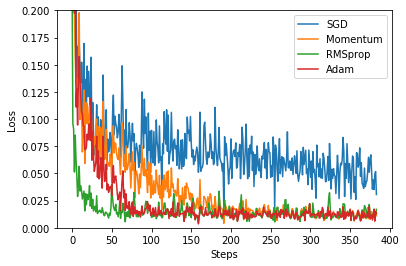

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
 
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12
 
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(x.size()))
 
#plt.scatter(x.numpy(), y.numpy())
#plt.show()
 
 
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
 
 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
 
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
 
 
if __name__ == '__main__':
    net_SGD = Net()
    net_Momentum = Net()
    net_RMSprop = Net()
    net_Adam = Net()
    nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]
 
    opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
    opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
    opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
    opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.999))
    optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]
 
    loss_func = torch.nn.MSELoss()
    losses_his = [[], [], [], []]
 
    for epoch in range(EPOCH):
        print('Epoch:', epoch)
        for step, (b_x, b_y) in enumerate(loader):
            for net, opt, l_his in zip(nets, optimizers, losses_his):
                output = net(b_x)
                loss = loss_func(output, b_y)
                opt.zero_grad()
                loss.backward()
                opt.step()
                l_his.append(loss.data.numpy())
 
    labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
    for i, l_his in enumerate(losses_his):
        plt.plot(l_his, label = labels[i])
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, 0.2))
    plt.show()